# Data Analysis Interview Challenge

## Imports

In [1]:
import json
from datetime import datetime
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

# Part 1 ‐ Exploratory data analysis

In [2]:
# Open file
file_path = '/Users/pandabear/springboard/Takehomeassignment_1/'
with open(file_path + 'logins.json') as f:
    data = json.load(f)


In [3]:
user_login = []

# Convert string to datetime format
for datetime_str in data['login_time']:
    user_login.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))

In [4]:
df = pd.DataFrame(user_login)
df.columns = ['login_datetime']
df.head()

,login_datetime
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.shape

(93142, 1)

In [6]:
# Convert the datetime data to 15 minute time intervals
df_interval = df.resample('15min', origin='start', on='login_datetime').count()

In [7]:
df_interval.columns = ['frequency']
df_interval = df_interval.reset_index()
df_interval.head()

,login_datetime,frequency
0,1970-01-01 20:12:16,8
1,1970-01-01 20:27:16,8
2,1970-01-01 20:42:16,6
3,1970-01-01 20:57:16,3
4,1970-01-01 21:12:16,3


In [8]:
# Add another column to denote the day of the week
df_interval['day_of_week'] = df_interval['login_datetime'].apply(lambda x: x.day_of_week)

In [9]:
df_interval.head()

,login_datetime,frequency,day_of_week
0,1970-01-01 20:12:16,8,3
1,1970-01-01 20:27:16,8,3
2,1970-01-01 20:42:16,6,3
3,1970-01-01 20:57:16,3,3
4,1970-01-01 21:12:16,3,3


In [10]:
day_of_week_conversion = {0:'Monday',
                         1:'Tuesday',
                         2:'Wednesday',
                         3:'Thursday',
                         4:'Friday',
                         5:'Saturday',
                         6:'Sunday'}

df_interval.loc[:,'day_of_week_w'] = df_interval.day_of_week.map(day_of_week_conversion)

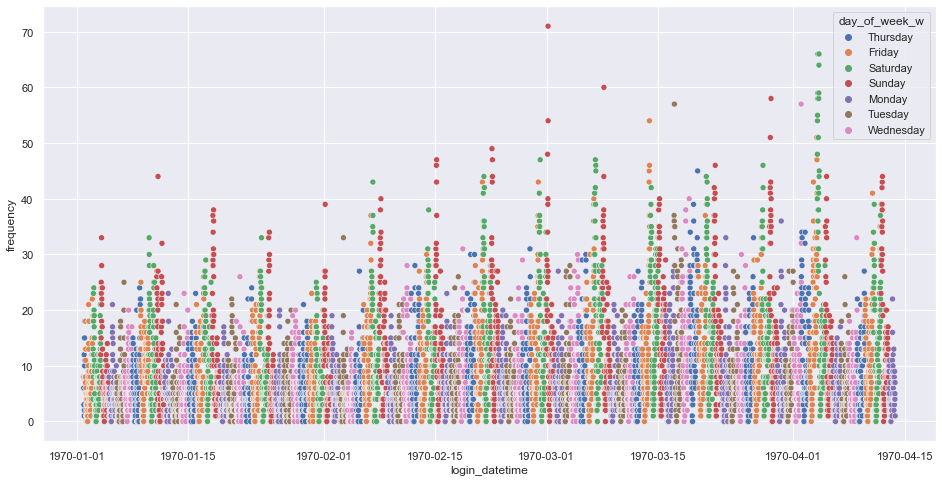

In [12]:
# Plot the demand for all timestamps
sns.set(rc={"figure.figsize":(16, 8)}) #width=8, height=4
chart = sns.scatterplot(data=df_interval, x = 'login_datetime', y = 'frequency', hue='day_of_week_w')

There is a clear weekly where the ride frequency is highest Saturday and Sunday than the rest of the week. The lowest days of demand are monday, and increase over the weekdays with friday being the highest weekday.

In [13]:
# To look at daily cycles, plot a smaller length of datetime stamps
# In 24 hours, there are 4/hr * 24 hours = 96 data points. In a 7 day week there are 672 data points.

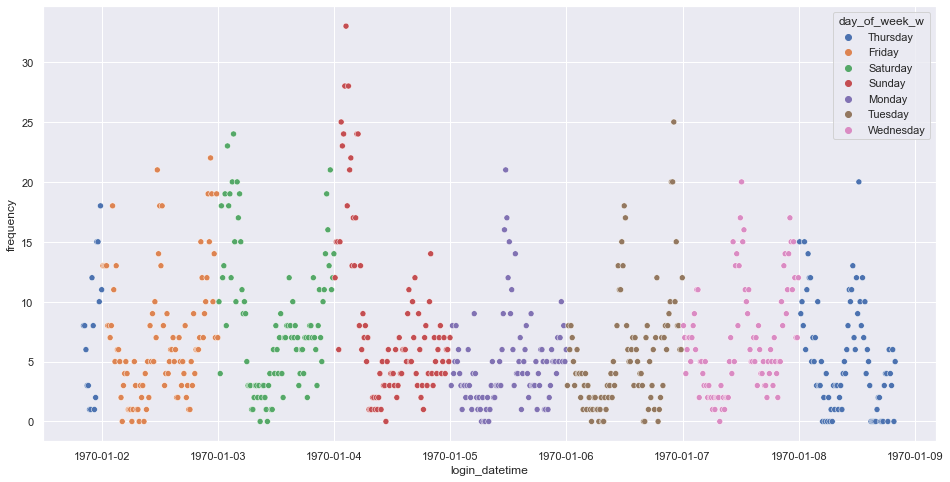

In [14]:
# Plot the demand for the first 7 days
sns.set(rc={"figure.figsize":(16, 8)}) #width=8, height=4
chart = sns.scatterplot(data=df_interval[:672], x = 'login_datetime', y = 'frequency', hue='day_of_week_w')
#672

There is a clear daily cycle that peaks at midnight, drops in the morning, peaks at midday, drops duing the afternoon and peaks again in the evening. 

# Part 2 ‐ Experiment and metrics design

1)Metric to test: I would choose percentage of all drivers that pick up a minimum of 20% rides from both Gotham and Metropolis as the key measure of success of this experiment to test that driver partners are serving both cities. This is to ensure that drivers are crossing the toll bridge and are picking up riders from both cities, otherwise the percentage would be 0% if they stayed in only 1 of the cities.

A/B Test Experiment Design:  The null hypothesis is that reimbursing for bridge tolls both ways does not change the metric. The alternative hypothesis is that reimbursing for bridge tolls both ways does change the metric of interest.

2a) Define Thresholds: statistical significance level alpha = 0.05, power = 0.8, Minimum detectable effect MDE = 1%
The sample size would be all drivers in Gotham and Metropolis. Drivers would be randomly selected to be in the control and treatment group.
The experiment length would be a minimum of 2 weeks to capture day of week and weekly effects.

2b) The Statistical test to conduct to verify the significance of the observed metric in the A/B test would be a paired t test. 

2c) Interpret the results by comparing the p-value of the experiment and if it is smaller than an alpha of 0.05, reject the null hypothesis and conclude that this experiment does improve coverage of driving partners for both Gotham and Metropolis.

# Part 3 ‐ Predictive modeling

In [15]:
# Open file
file_path = '/Users/pandabear/springboard/Takehomeassignment_1/'
with open(file_path + 'ultimate_data_challenge.json') as file:
    ultimate_data = json.load(file) 

In [16]:
ultimate_df = pd.DataFrame(ultimate_data)

In [17]:
ultimate_df.shape
total_users = ultimate_df.shape[0]

In [18]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [19]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


array([[<AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'avg_rating_of_driver'}>,
        <AxesSubplot:title={'center':'avg_surge'}>],
       [<AxesSubplot:title={'center':'surge_pct'}>,
        <AxesSubplot:title={'center':'weekday_pct'}>,
        <AxesSubplot:title={'center':'avg_dist'}>],
       [<AxesSubplot:title={'center':'avg_rating_by_driver'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

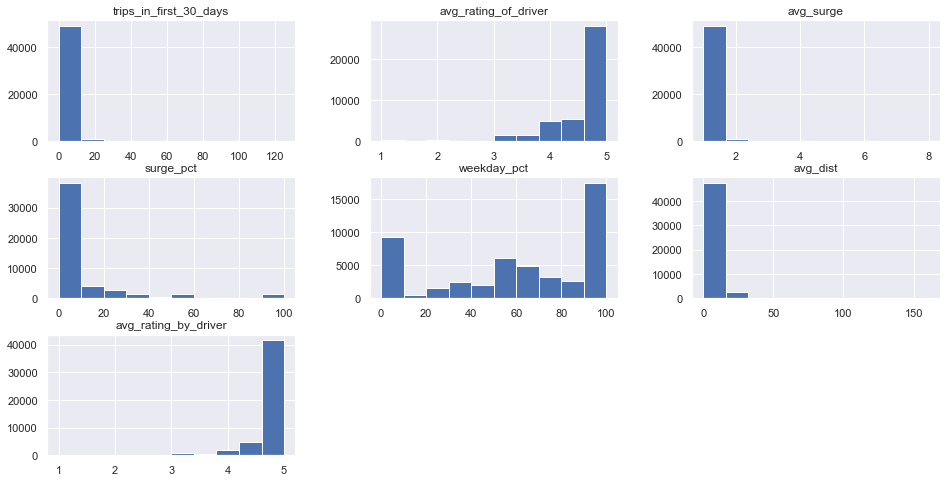

In [20]:
ultimate_df.hist()

In [21]:
ultimate_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [22]:
# Convert the signup_date and last_trip_date column into datetime
ultimate_df.loc[:,'signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df.loc[:,'last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])


In [23]:
ultimate_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [24]:
ultimate_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

These missing values don't affect the analysis and are ok to leave in the dataset.

<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='count'>

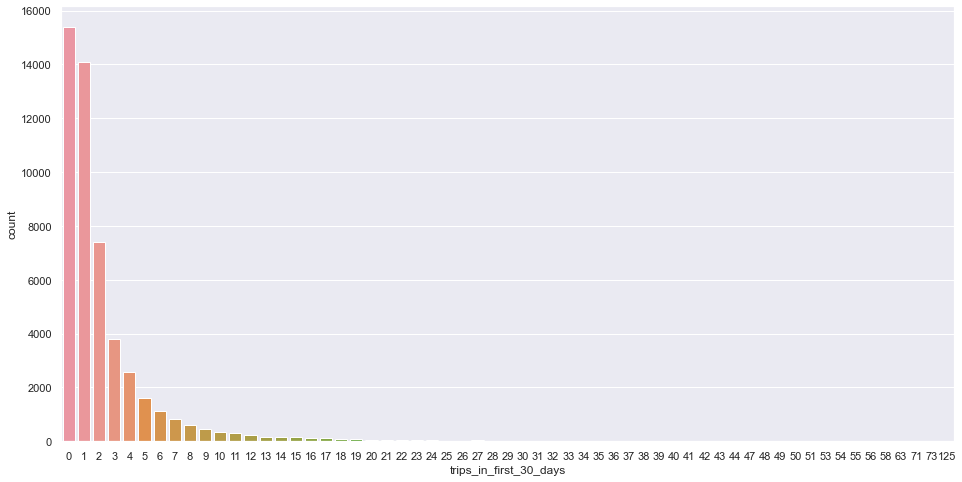

In [25]:
# Look at the distribution of rides taken in the first 30 days
sns.countplot(x=ultimate_df['trips_in_first_30_days'])

In [26]:
retained_users = pd.DataFrame({'no_rides_taken_%':[ultimate_df[ultimate_df['trips_in_first_30_days'] == 0].shape[0]*100/total_users], 
                               'taken_rides_%':[ultimate_df[ultimate_df['trips_in_first_30_days'] >= 1].shape[0]*100/total_users]}, 
                              index=['Number of users'])



In [27]:
retained_users

,no_rides_taken_%,taken_rides_%
Number of users,30.78,69.22


This shows that 69% of observed users were retained.

[Text(0.5, 0, 'Number of rides taken'),
 Text(0, 0.5, 'Percentage'),
 Text(0.5, 1.0, 'Percentage of retained users in the first 30 days of signing up')]

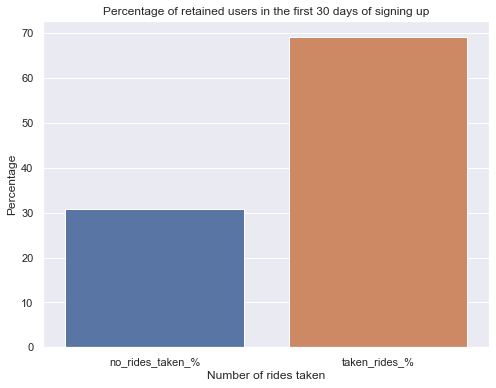

In [28]:
sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.barplot(data=retained_users)
ax.set(xlabel='Number of rides taken',
       ylabel='Percentage',
       title='Percentage of retained users in the first 30 days of signing up')

## 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. 
Choose to build a logistic regression supervised machine learning model to predict whether a user will be active in their 6th month after signing up. This is a simple model to start with and easy to tune, as well as being less likely to overfit. An alternative model considered could be a Random Forest model, which would handle categorical variables without needing to one hot encode them, but it is less of a concern with this dataset as there are only 3 categorical variables. A Random Forest model would also be faster to train since you can fully parallelize building of trees, but is prone to overfitting.

Look at training and testing scores, especially the f1 score since this dataset is imbalanced. 
Also time how long the model takes to train.


To determine whether or not a user will be active (defined as taking 1 or more trips) in their 6th month after signing up, a new labeled column will need to be created. Create a column called 6_month_active where if the user's last trip date is between 150 to 180 days since their signup date regardless of whether or not they have taken a trip in the first 30 days then label as 1, otherwise label as 0.


In [29]:
ultimate_df.shape

(50000, 12)

In [30]:
cut_off_date = ultimate_df['last_trip_date'].max()
cut_off_date

Timestamp('2014-07-01 00:00:00')

In [31]:
def in_6_months(signup_date,cut_off_date):
    if (cut_off_date - signup_date).days >= 150 and (cut_off_date - signup_date).days <= 180:
        return 1
    else:
        return 0
    
    
# Only keep users that have a difference of 150 to 180 
ultimate_df['in_6_months'] = ultimate_df.apply(lambda x: in_6_months(x['signup_date'],cut_off_date), axis=1)


ultimate_df = ultimate_df[ultimate_df['in_6_months'] == 1]

# Drop unused column
ultimate_df.drop(['in_6_months'], axis=1, inplace=True)

In [32]:
def active_after_6_months(signup_date, last_ride_date):
    if (last_ride_date - signup_date).days >= 150 and (last_ride_date - signup_date).days <= 180:
        return 1
    else:
        return 0

In [33]:
ultimate_df.shape

(48263, 12)

In [34]:
# Create column '6_month_active'
ultimate_df['6_month_active'] = ultimate_df.apply(lambda x: active_after_6_months(x['signup_date'],x['last_trip_date']),axis=1)



In [35]:
ultimate_df['6_month_active'].value_counts(normalize=True)

0    0.751549
1    0.248451
Name: 6_month_active, dtype: float64

This classification problem is imbalanced, as only 24% of users have done a trip 6 months after their sign up date. Let's build a supervised logistic regression model to predict whether or not a user will complete a ride at Ultimate in their 6th month. 

In [36]:
# Convert the datetime features into days as this better represents the relationship between signup and activity as a user.
ultimate_df['no_days_since_signup'] = ultimate_df['signup_date'].apply(lambda x: (cut_off_date - x).days)
ultimate_df['no_days_since_last_ride'] = ultimate_df['last_trip_date'].apply(lambda x: (cut_off_date - x).days)



In [37]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6_month_active,no_days_since_signup,no_days_since_last_ride
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,157,14
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,153,57
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,176,175
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,172,2
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,155,108


In [38]:
ultimate_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', '6_month_active', 'no_days_since_signup',
       'no_days_since_last_ride'],
      dtype='object')

In [39]:
# Convert categorical features using one hot encoding
ultimate_df = ultimate_df.dropna()
transformer = make_column_transformer(
    (OneHotEncoder(), ['city', 'phone','ultimate_black_user']),
    remainder='passthrough')

transformed = transformer.fit_transform(ultimate_df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
print(transformed_df.head())

  onehotencoder__x0_Astapor onehotencoder__x0_King's Landing  \
0                       0.0                              1.0   
1                       1.0                              0.0   
2                       1.0                              0.0   
3                       0.0                              1.0   
4                       0.0                              0.0   

  onehotencoder__x0_Winterfell onehotencoder__x1_Android  \
0                          0.0                       0.0   
1                          0.0                       1.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          1.0                       1.0   

  onehotencoder__x1_iPhone onehotencoder__x2_False onehotencoder__x2_True  \
0                      1.0                     0.0                    1.0   
1                      0.0                     1.0                    0.0   
2                      

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
transformed_df.columns = [['city_Astapor',
 "city_King's_Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone',
 'ultimate_black_user_False',
 'ultimate_black_user_True',
 'trips_in_first_30_days',
 'signup_date',
 'avg_rating_of_driver',
 'avg_surge',
 'last_trip_date',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 '6_month_active',
 'no_days_since_signup',
 'no_days_since_last_ride']]

In [41]:
X = transformed_df[['city_Astapor',
 "city_King's_Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone',
 'ultimate_black_user_False',
 'ultimate_black_user_True',
 'trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver']]
y = transformed_df['6_month_active'].astype('int').to_numpy()[:,0]

In [42]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
X

,city_Astapor,city_King's_Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4,4.7,1.1,15.4,46.2,3.67,5.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,5.0,1.0,0.0,50.0,8.26,5.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3,4.3,1.0,0.0,100.0,0.77,5.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,9,4.6,1.14,20.0,80.0,2.36,4.9
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,14,4.4,1.19,11.8,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3,4.8,1.11,11.1,55.6,2.53,4.7
40056,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,4.6,1.44,37.5,25.0,2.25,4.5
40057,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,5.0,1.0,0.0,100.0,5.63,4.2
40058,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,5.0,1.0,0.0,100.0,3.86,5.0


In [44]:
# Split the data into training and testing sets, choose 30% test data
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Save the column names and index for later
X_train_columns = X_train.columns
X_train_index = X_train.index
X_test_index = X_test.index


start_time = datetime.now()
scaler = StandardScaler()
p = Pipeline([('standardize', scaler)])

X_train = pd.DataFrame(p.fit_transform(X_train))
X_test = pd.DataFrame(p.transform(X_test))

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [45]:
# Assign index and column names back
X_train.index = X_train_index
X_test.index = X_test_index
X_train.columns = X_train_columns
X_test.columns = X_train_columns

In [46]:
X_train

,city_Astapor,city_King's_Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
25779,1.420859,-0.516255,-0.919828,1.560396,-1.560396,0.788464,-0.788464,0.085183,-0.967180,2.647713,1.333512,0.150998,-0.378354,0.550482
18479,1.420859,-0.516255,-0.919828,-0.640863,0.640863,0.788464,-0.788464,-0.399437,0.647262,-0.382809,-0.485422,1.107423,-0.529532,0.550482
37826,1.420859,-0.516255,-0.919828,1.560396,-1.560396,0.788464,-0.788464,0.085183,0.647262,-0.382809,-0.485422,0.150998,-0.529532,0.550482
30799,-0.703800,-0.516255,1.087160,-0.640863,0.640863,-1.268289,1.268289,-0.399437,0.647262,-0.382809,-0.485422,1.107423,5.296657,0.550482
16355,-0.703800,-0.516255,1.087160,1.560396,-1.560396,-1.268289,1.268289,-0.641747,0.647262,-0.382809,-0.485422,-1.764723,-0.434561,0.550482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1.420859,-0.516255,-0.919828,1.560396,-1.560396,0.788464,-0.788464,1.296732,0.162930,-0.382809,-0.485422,0.443957,0.024789,0.055306
11284,1.420859,-0.516255,-0.919828,-0.640863,0.640863,0.788464,-0.788464,0.085183,-0.967180,-0.382809,-0.485422,0.150998,0.069367,0.550482
38158,-0.703800,-0.516255,1.087160,-0.640863,0.640863,0.788464,-0.788464,-0.399437,0.647262,-0.382809,-0.485422,-1.764723,2.369995,0.550482
860,-0.703800,1.937028,-0.919828,-0.640863,0.640863,-1.268289,1.268289,0.327493,-0.159959,1.289203,2.245710,0.245779,-0.628380,-0.192282


In [47]:
# Find best hyperparameters using GridSearch, cv=5
sgdc = SGDClassifier(penalty='l2', class_weight='balanced')
parameters = [
    {'alpha':[0.00001, 0.0001, 0.001, 0.005]},
    {'max_iter': [10000]},
]
cv = GridSearchCV(estimator = sgdc,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0)


cv.fit(X_train.values, y_train)   
model = cv.best_estimator_

## Training Score

In [48]:
y_train_hat = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_auc_roc = roc_auc_score(y_train, model.decision_function(X_train))*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))

print('Training AUC: %.2f %%' % train_auc_roc)

print('Training accuracy: %.2f %%' % train_accuracy)

Confusion matrix:
 [[13612  6637]
 [ 2549  5244]]
Training AUC: 73.03 %
Training accuracy: 67.24 %


/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


## Testing Score

In [49]:
y_test_hat = model.predict(X_test)
# y_test_hat_probs = model.predict_proba(X_test)[:,1]

test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_auc_roc = roc_auc_score(y_test, model.decision_function(X_test))*100

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))

print('Testing AUC: %.4f %%' % test_auc_roc)

print('Testing accuracy: %.4f %%' % test_accuracy) 

Confusion matrix:
 [[5822 2902]
 [1081 2213]]
Testing AUC: 72.7438 %
Testing accuracy: 66.8580 %


/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [50]:
print(classification_report(y_test, y_test_hat, digits=3))

              precision    recall  f1-score   support

           0      0.843     0.667     0.745      8724
           1      0.433     0.672     0.526      3294

    accuracy                          0.669     12018
   macro avg      0.638     0.670     0.636     12018
weighted avg      0.731     0.669     0.685     12018



In [51]:
# Look at unit feature importance to show the top the features with the most influence on whether a person will be an active user at month 6
model.coef_

array([[-0.2850012 ,  0.33312669, -0.00330827, -0.21469968,  0.21469968,
        -0.22298297,  0.22298297,  0.44601221, -0.00830456, -0.00899187,
         0.07686068,  0.0258314 , -0.22948368, -0.0866478 ]])

In [52]:
model_coef_df = pd.DataFrame(model.coef_, columns = X_train.columns).T
model_coef_df.columns = ['model_coef']
model_coef_df.sort_values(by=['model_coef'], ascending=False)

,model_coef
trips_in_first_30_days,0.446012
city_King's_Landing,0.333127
ultimate_black_user_True,0.222983
phone_iPhone,0.214700
surge_pct,0.076861
weekday_pct,0.025831
city_Winterfell,-0.003308
avg_rating_of_driver,-0.008305
avg_surge,-0.008992
avg_rating_by_driver,-0.086648


## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention.

**This model shows that features most positively correlated to long term rider retention (defined as taking atleast a ride in the 6th month post sign up) are (in order of importance):**
1. If the user took a trip in their first 30 days after signing up for an account
2. If the user signed up in the city 'King's Landing'
3. If the user took an Ultimate Black in their first 30 days after signing up for an account
4. If the user has an Iphone as opposed to an Android


**The features most negatively correlated to long term rider retention are:**
1. If the user signed up in the city 'Astapor'
2. The average distance in miles per trip taken in the first 30 days after signup
3. If the user did not take an Ultimate Black in their first 30 days after signing up for an account
4. If the user has an Android phone

**Thus, Ultimate should focus their marketing, promotions and user retention efforts on these negatively correlated key aspects of users to increase their rider retention**